In [6]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
from sklearn import preprocessing
import numpy as np
import time
import os
from PIL import Image
import json
from pathlib import Path
import numpy as np
from sklearn.preprocessing import normalize
from datetime import datetime
import random
import matplotlib.pyplot as plt # plt 用於顯示圖片
import matplotlib.image as mpimg # mpimg 用於讀取圖片

In [7]:
# Replace with valid values
#確認以下這些東西有無正確
ENDPOINT = "https://testod.cognitiveservices.azure.com/"
training_key = "305b1fb89c6c447ea1a4a1645885c1ac"
prediction_key = "ff834bf5c2ed4855be628a6bf23624c5"
prediction_resource_id = "/subscriptions/6bb19610-9077-414c-971c-e545a2e35961/resourceGroups/test/providers/Microsoft.CognitiveServices/accounts/testOD-Prediction"
#publish_iteration_name = "Iteration4"
project_id = "d42b6a11-eb79-404a-81db-beb0f4e485ba"
#iteration_id = "ee16938c-d504-49b9-8ab7-75457c735079"

## 範例
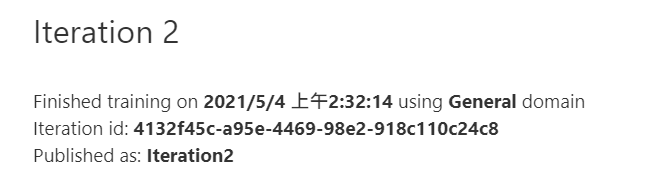

In [8]:
credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(ENDPOINT, credentials)
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

In [9]:
# Make two tags in the new project
category_dict = { 1 :'short_sleeve_top', 2 :'long_sleeve_top', 3 :'short_sleeve_outwear', 4 :'long_sleeve_outwear', 
                  5 :'vest', 6 :'sling', 7 :'shorts', 8 :'trousers', 9 :'skirt', 10 :'short_sleeve_dress', 
                  11 :'long_sleeve_dress', 12 :'vest_dress', 13 :'sling_dress'}
regions_arr = [0] * 13
key_arr = [0] * 13
value_arr = [0] * 13
for i in range(1,14):
    category = category_dict.get(i)
    str_category = str(category)
    key_name = str_category + '_key'
    value_name = str_category + '_value'
    key_arr[i-1] = key_name
    value_arr[i-1] = value_name
    #tag_name = str_category + '_tag'
    #tag_name = trainer.create_tag(project.id, str_category)
    regions_name = str_category + '_regions'
    regions_arr[i-1] = regions_name
    #regions_name = {}
    
#這邊應該可以再優化
sling_dress_tag = trainer.create_tag(project_id, "sling dress") 
vest_dress_tag = trainer.create_tag(project_id, "vest dress")
short_sleeve_dress_tag = trainer.create_tag(project_id, "short sleeve dress")
sling_tag = trainer.create_tag(project_id, "sling")
vest_tag = trainer.create_tag(project_id, "vest")
long_sleeve_outwear_tag = trainer.create_tag(project_id, "long sleeve outwear")
short_sleeve_outwear_tag = trainer.create_tag(project_id, "short sleeve outwear")
long_sleeve_top_tag = trainer.create_tag(project_id, "long sleeve top")
long_sleeve_dress_tag = trainer.create_tag(project_id, "long sleeve dress")
short_sleeve_top_tag = trainer.create_tag(project_id, "short sleeve top")
skirt_tag = trainer.create_tag(project_id, "skirt")
shorts_tag = trainer.create_tag(project_id, "shorts")
trousers_tag = trainer.create_tag(project_id, "trousers")


CustomVisionErrorException: Name not unique: sling dress, Project: d42b6a11-eb79-404a-81db-beb0f4e485ba

In [ ]:
#建一個資料夾 裡面放圖片跟json檔
base_location = 'C:/Users/JIALI/Desktop/project/VProject/train/image/'
#json_p = 'C:/Users/qingyu/Desktop/yutest/'
jList = os.listdir(base_location)

#這邊應該可以再優化
short_sleeve_top_regions = {}
long_sleeve_top_regions = {}
short_sleeve_outwear_regions = {}
long_sleeve_outwear_regions = {}
vest_regions = {}
sling_regions = {}
shorts_regions = {}
trousers_regions = {}
skirt_regions = {}
short_sleeve_dress_regions = {}
long_sleeve_dress_regions = {}
vest_dress_regions = {}
sling_dress_regions = {}

tag_num = 0

for file in jList:
    
    if file.endswith(".jpg"):
        img = Image.open( os.path.join(base_location,file))
        imgSize = img.size  #大小/尺寸
        pw = img.width       #图片的宽
        ph = img.height      #图片的高
        pf = img.format      #图像格式
     
        
# Region Left(rl) = X1 / Image Width
# Region Top(rt) = Y1 / Image Height
# Region Width(rw) = (X2 — X1) / image Width
# Region Height(rh)= (Y2 — Y1) / image Height
    
    if file.endswith(".json"):
        with open(os.path.join(base_location,file) , 'r') as reader:
            jf = json.loads(reader.read())
        strjf = str(jf)
        maxi = strjf.count('item') + 1
        for i in range (1,maxi):
            stri = str(i)
            category_id = jf['item'+stri]['category_id']
            category_name = category_dict.get(category_id)
            rl = jf['item'+stri]['bounding_box'][0]/pw
            rt = jf['item'+stri]['bounding_box'][1]/ph
            rw = (jf['item'+stri]['bounding_box'][2]-jf['item'+stri]['bounding_box'][0])/pw
            rh = (jf['item'+stri]['bounding_box'][3]-jf['item'+stri]['bounding_box'][1])/ph
            regions = category_name + '_regions'
            if regions in regions_arr:
                mydict = eval(regions)
                mydict[Path(file).stem]=[rl,rt,rw,rh,category_name]
                tag_num = tag_num + 1  
    if(tag_num>=200):#因為在免費模式 要小於5000張
        break;

In [11]:
# Update this with the path to where you downloaded the images.
# Go through the data table above and create the images

#土法煉鋼   先找到那個種類的tag id
#print(eval('long_sleeve_top_tag').id)

print(trainer.get_tag(project_id))
print ("Adding images...")
total_count = 0
def upload():
    global total_count 
    count=0
    tagged_images_with_regions = []
    length = len(regions_arr)
    for i in range(0,length):
        key_arr[i] = list(eval(regions_arr[i]))
        value_arr[i] = list(eval(regions_arr[i]).values())
        for file_name in key_arr[i]:
            index = key_arr[i].index(file_name)
            x,y,w,h,c = value_arr[i][index]
            regions = c + '_regions'
            regions_dict = eval(regions)
            del regions_dict[file_name]
            key_arr[i] = list(regions_dict)
            value_arr[i] = list(regions_dict.values())
            tag = c + '_tag'
            #這裡改成那個種類的id!!
            regions = [ Region(tag_id='761f6e23-3174-4f17-b36d-bdde607d8471', left=x,top=y,width=w,height=h) ] 
            count=count+1
            total_count = total_count+1
            with open(base_location  + file_name + ".jpg", mode="rb") as image_contents:
                tagged_images_with_regions.append(ImageFileCreateEntry(name=file_name, contents=image_contents.read(), regions=regions))
           
            if(count>=64):
                print("count",count)
                print("total_count",total_count)
                break
        else:
            continue
        break
                
            
    upload_result = trainer.create_images_from_files(project_id, ImageFileCreateBatch(images=tagged_images_with_regions))

    tagged_images_with_regions.clear()

    if not upload_result.is_batch_successful:
        print("Image batch upload failed.")
        for image in upload_result.images:
            print("Image status: ", image.status)
        exit(-1)
#end upload    

maxn = int(tag_num/64) + 1
for n in range (0,maxn): 
    upload()
    print(n)
#for n in range (0,maxn): upload()  


TypeError: get_tag() missing 1 required positional argument: 'tag_id'

In [40]:
print (total_count)#281-16 10分鐘   #4792-11
t1 = time.time()
print (time.asctime( time.localtime(t1) ))
print ("Training...")

iteration = trainer.train_project(project_id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project_id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(60)
t2 = time.time()
print (time.asctime( time.localtime(t2) ))
print ("花費時間",str(round((t2-t1)/60,2)),"分鐘")

57
Sat May 29 17:24:41 2021
Training...


CustomVisionErrorException: Not enough images per tag for training

In [ ]:
# The iteration is now trained. Publish it to the project endpoint
#trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, prediction_resource_id)

trainer.publish_iteration(project_id, iteration_id , publish_iteration_name ,  prediction_resource_id)

print ("Done!")

In [ ]:
# Now there is a trained endpoint that can be used to make a prediction

# Open the sample image and get back the prediction results.
test_path ="C:/Users/JIALI/Desktop/project/VProject/validation/image/"
   
def quicktest():
    
    img = str(random.randint(0,9999)).zfill(6)+".jpg"
    lena = mpimg.imread(test_path+img)
    plt.imshow(lena)
    plt.axis('off') # 不顯示座標軸
    print(img)
    plt.show()
    with open(test_path+img, mode="rb") as test_data:#記得改project id
        results = predictor.detect_image(project_id,publish_iteration_name, test_data)
   
    count = 1
# Display the results.    
    for prediction in results.predictions:
        if(count<4):
            print("\t第"+str(count)+"高的標籤：" + prediction.tag_name + ": {0:.2f}% bbox.left = {1:.2f}, bbox.top = {2:.2f}, bbox.width = {3:.2f}, bbox.height = {4:.2f}".format(prediction.probability * 100, prediction.bounding_box.left, prediction.bounding_box.top, prediction.bounding_box.width, prediction.bounding_box.height))
            count = count+1
#         else:
#             print("\t" + prediction.tag_name + ": {0:.2f}% bbox.left = {1:.2f}, bbox.top = {2:.2f}, bbox.width = {3:.2f}, bbox.height = {4:.2f}".format(prediction.probability * 100, prediction.bounding_box.left, prediction.bounding_box.top, prediction.bounding_box.width, prediction.bounding_box.height))

for i in range(1,10):
    quicktest()